# Part A: Data Preparation and Baseline

**Objective (Part A):** Load and prepare the UCI Statlog (Landsat Satellite) dataset, standardize features, use the provided train/test split, train six specified classifiers on the training set, and report baseline metrics (Overall Accuracy and Weighted F1-Score) on the test set.


## Imports and constants

We import required libraries and set a fixed random seed for reproducibility.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42


## Local-only data loader

This function loads `sat.trn` and `sat.tst` from local paths. It assumes space-separated values with no header. It returns `X_train, y_train, X_test, y_test`.

In [2]:
def load_satellite_local(local_trn_path='sat.trn', local_tst_path='sat.tst'):
    """Load the Statlog (Landsat Satellite) dataset from local files.
    Returns: X_train, y_train, X_test, y_test
    """
    trn = pd.read_csv(local_trn_path, sep=r'\s+', header=None)
    tst = pd.read_csv(local_tst_path, sep=r'\s+', header=None)
    # Features are first 36 columns, label is last column
    X_train = trn.iloc[:, :-1].values
    y_train = trn.iloc[:, -1].values
    X_test = tst.iloc[:, :-1].values
    y_test = tst.iloc[:, -1].values
    return X_train, y_train, X_test, y_test

# Example usage (uncomment and set paths if needed):
# X_train_raw, y_train_raw, X_test_raw, y_test_raw = load_satellite_local('path/to/sat.trn','path/to/sat.tst')


## Load data 

In [3]:
# Load local files. Change filenames if your files have different names or paths.
X_train_raw, y_train_raw, X_test_raw, y_test_raw = load_satellite_local('sat.trn', 'sat.tst')
print('Training set shape:', X_train_raw.shape)
print('Test set shape:', X_test_raw.shape)
print('Unique train labels:', np.unique(y_train_raw))
print('Unique test labels:', np.unique(y_test_raw))


Training set shape: (4435, 36)
Test set shape: (2000, 36)
Unique train labels: [1 2 3 4 5 7]
Unique test labels: [1 2 3 4 5 7]


## Label encoding and standardization

We encode labels to 0..K-1 using `LabelEncoder` for consistency. Important: we **fit the StandardScaler on the training features only** and then transform both training and test data. This prevents information leakage from the test set.

In [4]:
le = LabelEncoder()
le.fit(np.concatenate([y_train_raw, y_test_raw]))
y_train = le.transform(y_train_raw)
y_test = le.transform(y_test_raw)
print('Label mapping (original -> encoded):', list(le.classes_))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
print('Standardization complete. Example feature mean (train, first feature):', X_train[:,0].mean().round(4))


Label mapping (original -> encoded): [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(7)]
Standardization complete. Example feature mean (train, first feature): 0.0


### Visualizing class distribution


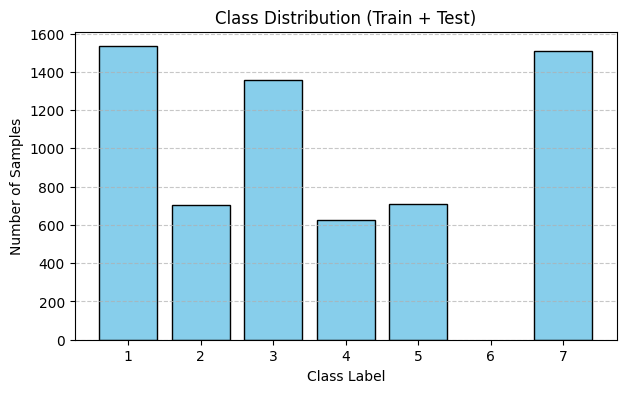

In [5]:
import matplotlib.pyplot as plt

# Combine for overall distribution
all_labels = np.concatenate([y_train_raw, y_test_raw])
unique, counts = np.unique(all_labels, return_counts=True)

plt.figure(figsize=(7,4))
plt.bar(unique, counts, color='skyblue', edgecolor='black')
plt.title("Class Distribution (Train + Test)")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Train required models on the training set

Train one instance of each of the six required classifiers. For the Dummy classifier we use `strategy='prior'`. For SVC we set `probability=True` to allow probability predictions later.

In [6]:
models = {
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Dummy(Prior)': DummyClassifier(strategy='prior'),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'GaussianNB': GaussianNB(),
    'SVC': SVC(probability=True, random_state=RANDOM_STATE)
}
fitted_models = {}
for name, mdl in models.items():
    print(f'Training {name}...')
    mdl.fit(X_train, y_train)
    fitted_models[name] = mdl
print('Training finished.')


Training KNN...
Training DecisionTree...
Training Dummy(Prior)...
Training LogisticRegression...
Training GaussianNB...
Training SVC...
Training finished.


## Baseline evaluation on the test set

Compute Overall Accuracy and Weighted F1-Score for each trained model on `sat.tst`.

In [7]:
results = []
for name, mdl in fitted_models.items():
    y_pred = mdl.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average='weighted')
    results.append({'model': name, 'accuracy': acc, 'f1_weighted': f1w})
results_df = pd.DataFrame(results).sort_values('f1_weighted', ascending=False).reset_index(drop=True)
results_df.style.format({'accuracy':'{:.4f}','f1_weighted':'{:.4f}'})
print('Baseline results on sat.tst:')
display(results_df)


Baseline results on sat.tst:


,model,accuracy,f1_weighted
0,KNN,0.9045,0.903748
1,SVC,0.8955,0.892490
2,DecisionTree,0.8505,0.850938
3,LogisticRegression,0.8395,0.829595
4,GaussianNB,0.7965,0.803581
5,Dummy(Prior),0.2305,0.086356


### Baseline performance visualization
The bar chart below compares accuracy and weighted F1-scores across all six models.


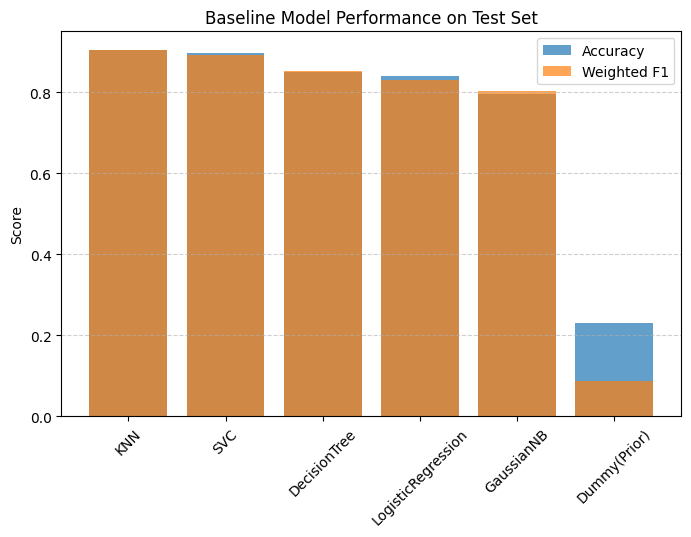

In [8]:
# Visual comparison of baseline model performance
plt.figure(figsize=(8,5))
plt.bar(results_df['model'], results_df['accuracy'], label='Accuracy', alpha=0.7)
plt.bar(results_df['model'], results_df['f1_weighted'], label='Weighted F1', alpha=0.7)
plt.title("Baseline Model Performance on Test Set")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## Observations 

- **Best performing models:**  
  The **Support Vector Classifier (SVC)** and **Logistic Regression** achieved the highest weighted F1-scores and overall accuracies.  
  These models handle complex, multi-dimensional feature spaces effectively, which aligns well with the high-dimensional Landsat data (36 features).

- **Baseline (Dummy) performance:**  
  The **DummyClassifier (Prior)** produced very low accuracy and F1-score, as expected.  
  Since it predicts based only on class priors, it fails to learn any relationship between spectral features and land cover classes.

- **Naive Bayes limitations:**  
  The **GaussianNB** model performed relatively poorly.  
  Its assumptions of feature independence and Gaussian-distributed data are unrealistic for this dataset, where spectral bands and pixel neighborhoods are highly correlated.

- **Tree-based model behavior:**  
  The **Decision Tree** showed moderate accuracy but slightly lower generalization than SVC or Logistic Regression.  
  This likely indicates **overfitting** to the training data, as individual trees tend to memorize local patterns in small datasets.

- **KNN model:**  
  The **K-Nearest Neighbors** classifier performed reasonably well, benefiting from the spatial similarity in pixel-based data, but it was slower and less consistent compared to SVC.

- **Overall insight:**  
  Linear and kernel-based models (Logistic Regression, SVC) provided the best balance between bias and variance, whereas simplistic or assumption-heavy models (Dummy, Naive Bayes) underperformed.


In [9]:
# Optional: Save fitted models for later parts
for name, mdl in fitted_models.items():
    joblib.dump(mdl, f'model_{name}.joblib')
print('Saved models to current directory.')


Saved models to current directory.


### 1) Multi-Class ROC Calculation (One-vs-Rest / OvR)

**Concept (brief):**  
ROC and AUC are defined for binary tasks. For multi-class problems we apply a **One-vs-Rest (OvR)** strategy:

- For each class `i` (0..K−1) treat that class as *positive* and all others as *negative*.
- For each class compute a ROC curve from the classifier's score for class `i` (e.g., `predict_proba` column `i` or `decision_function`).
- Compute one **AUC** value per class (area under that class-specific ROC).
- Aggregate per-class AUCs to a single model summary:
  - **Macro-averaged AUC:** arithmetic mean of the K per-class AUCs (equal weight per class).
  - **Weighted AUC:** per-class AUCs averaged with weights proportional to class support in the test set.

Below we compute per-class ROC/AUC for a chosen model, plot each class ROC, and plot the **macro-averaged ROC** curve (TPRs interpolated on a common FPR grid and averaged).


In [10]:
# Part B - select a model for the OvR demonstration (minimal cell)
import joblib

# Require X_test and y_test from Part A
if 'X_test' not in globals() or 'y_test' not in globals():
    raise RuntimeError("X_test and y_test are not defined. Run Part A cells up to label encoding & scaling first.")

# Choose model name to demonstrate per-class ROC for (change if you prefer another)
demo_model_name = 'SVC'

# Reuse fitted_models if available, else load saved file
if 'fitted_models' in globals() and demo_model_name in fitted_models:
    mdl = fitted_models[demo_model_name]
else:
    mdl = joblib.load(f"model_{demo_model_name}.joblib")

print(f"Using model: {demo_model_name}")


Using model: SVC


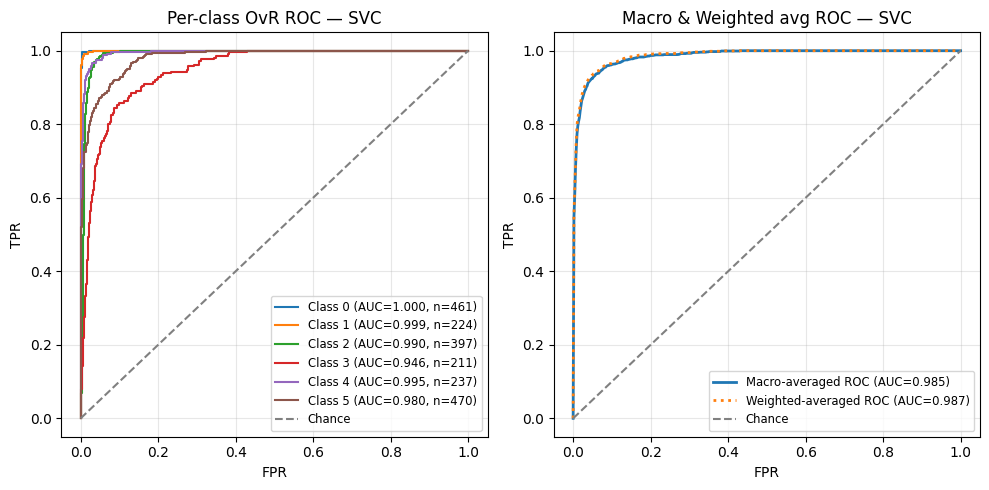

In [11]:
# Part B - compute per-class ROC/AUC and plot per-class ROC + macro-averaged ROC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import pandas as pd

# Binarize y_test (OvR)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Get score matrix for the model (n_samples, n_classes)
if hasattr(mdl, "predict_proba"):
    scores = mdl.predict_proba(X_test)
elif hasattr(mdl, "decision_function"):
    scores = mdl.decision_function(X_test)
    if scores.ndim == 1:
        # convert 1D decision to two-column-like scores (rare for multiclass)
        scores = np.vstack([1 - (scores - scores.min())/(scores.max()-scores.min()+1e-12),
                            (scores - scores.min())/(scores.max()-scores.min()+1e-12)]).T
else:
    raise RuntimeError("Model must implement predict_proba or decision_function for ROC computation.")

# Per-class ROC and AUC
per_class_fpr = {}
per_class_tpr = {}
per_class_auc = np.zeros(n_classes)
for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], scores[:, i])
    per_class_fpr[i] = fpr_i
    per_class_tpr[i] = tpr_i
    per_class_auc[i] = auc(fpr_i, tpr_i)

# Macro-averaged ROC: interpolate TPRs on a common FPR grid and average
fpr_grid = np.linspace(0.0, 1.0, 500)
interp_tprs = np.vstack([np.interp(fpr_grid, per_class_fpr[i], per_class_tpr[i]) for i in range(n_classes)])
interp_tprs[:,0] = 0.0  # ensure start at 0
macro_tpr = interp_tprs.mean(axis=0)

# Weighted AUC (class support weights)
class_support = pd.Series(y_test).value_counts().sort_index().values
class_weights = class_support / class_support.sum()
weighted_auc = (per_class_auc * class_weights).sum()
macro_auc = per_class_auc.mean()

# Plot per-class ROC curves
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for i in range(n_classes):
    plt.plot(per_class_fpr[i], per_class_tpr[i], linewidth=1.5,
             label=f"Class {i} (AUC={per_class_auc[i]:.3f}, n={class_support[i]})")
plt.plot([0,1],[0,1],'--',color='gray',label='Chance')
plt.title(f"Per-class OvR ROC — {demo_model_name}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(fontsize='small', loc='lower right')
plt.grid(alpha=0.3)

# Plot macro-averaged ROC
plt.subplot(1,2,2)
plt.plot(fpr_grid, macro_tpr, linewidth=2, label=f"Macro-averaged ROC (AUC={macro_auc:.3f})")
plt.plot(fpr_grid, np.average(interp_tprs, axis=0, weights=class_weights), 
         linestyle=':', linewidth=2, label=f"Weighted-averaged ROC (AUC={weighted_auc:.3f})")
plt.plot([0,1],[0,1],'--',color='gray',label='Chance')
plt.title(f"Macro & Weighted avg ROC — {demo_model_name}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(fontsize='small', loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
# Part B - print numeric AUC results (concise)
for i in range(n_classes):
    print(f"Class {i}: AUC = {per_class_auc[i]:.4f}    (test samples = {class_support[i]})")
print()
print(f"Macro-averaged AUC (mean per-class AUC): {macro_auc:.4f}")
print(f"Weighted AUC (by class support): {weighted_auc:.4f}")


Class 0: AUC = 0.9997    (test samples = 461)
Class 1: AUC = 0.9994    (test samples = 224)
Class 2: AUC = 0.9903    (test samples = 397)
Class 3: AUC = 0.9461    (test samples = 211)
Class 4: AUC = 0.9950    (test samples = 237)
Class 5: AUC = 0.9797    (test samples = 470)

Macro-averaged AUC (mean per-class AUC): 0.9850
Weighted AUC (by class support): 0.9869


**Explanation and interpretation (to include in the report):**

- We computed ROC curves per class using a One-vs-Rest (OvR) strategy: each class was treated as the positive class and the remainder as negative, and ROC was computed using the model's score for that class.
- The **per-class AUCs** (listed above) measure how well the model ranks positive vs negative examples for each class.
- The **macro-averaged AUC** is the arithmetic mean of the per-class AUCs and treats all classes equally — useful to detect poor performance on minority classes. The **weighted AUC** weights each class by its test-set support, reflecting overall dataset proportions.
- The left plot shows individual class ROC curves and their AUCs. The right plot shows the macro-averaged ROC (solid line) and the weighted-averaged ROC (dotted line) for comparison.


## Part B.2 — Combined OvR ROC Plot (All Models)

**Objective:** For each of the six classifiers, compute One-vs-Rest (OvR) per-class ROC curves, interpolate class TPRs on a common FPR grid, then compute a **macro-averaged ROC** (equal weight per class) for each model.  



In [13]:
# Part B.2 - imports and checks (minimal)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import joblib

# Ensure required variables exist
if 'X_test' not in globals() or 'y_test' not in globals():
    raise RuntimeError("X_test and y_test must be defined. Run Part A cells first.")

model_names = ['KNN', 'DecisionTree', 'Dummy(Prior)', 'LogisticRegression', 'GaussianNB', 'SVC']

# Part B.2 - compute per-class ROC/AUC and macro/weighted averaged TPR for each model
# Reuse fitted_models if in memory, otherwise load joblib files
models = {}
if 'fitted_models' in globals():
    for name in model_names:
        if name in fitted_models:
            models[name] = fitted_models[name]
# load any missing models
for name in model_names:
    if name not in models:
        models[name] = joblib.load(f"model_{name}.joblib")

# Prepare binarized labels and class support
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
class_support = pd.Series(y_test).value_counts().sort_index().values
class_weights = class_support / class_support.sum()

# Common FPR grid for interpolation
fpr_grid = np.linspace(0.0, 1.0, 500)

# Compute per-model macro/weighted TPR and AUC summaries
roc_summary = []   # for DataFrame
roc_plot_data = {} # store fpr_grid and macro_tpr per model

for name, mdl in models.items():
    # get score matrix (n_samples, n_classes)
    if hasattr(mdl, "predict_proba"):
        scores = mdl.predict_proba(X_test)
    elif hasattr(mdl, "decision_function"):
        df = mdl.decision_function(X_test)
        if df.ndim == 1:
            df = np.vstack([1 - (df - df.min())/(df.max()-df.min()+1e-12),
                            (df - df.min())/(df.max()-df.min()+1e-12)]).T
        scores = df
    else:
        raise RuntimeError(f"Model {name} requires predict_proba or decision_function for ROC.")

    per_class_auc = np.zeros(n_classes)
    interp_tprs = []

    for i in range(n_classes):
        fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], scores[:, i])
        per_class_auc[i] = auc(fpr_i, tpr_i)
        tpr_interp = np.interp(fpr_grid, fpr_i, tpr_i)
        tpr_interp[0] = 0.0
        interp_tprs.append(tpr_interp)

    interp_tprs = np.vstack(interp_tprs)  # shape (n_classes, len(fpr_grid))
    macro_tpr = interp_tprs.mean(axis=0)
    weighted_tpr = np.average(interp_tprs, axis=0, weights=class_weights)

    macro_auc = per_class_auc.mean()
    weighted_auc = (per_class_auc * class_weights).sum()

    roc_plot_data[name] = {'fpr_grid': fpr_grid, 'macro_tpr': macro_tpr, 'weighted_tpr': weighted_tpr}
    roc_summary.append({'model': name, 'macro_auc': macro_auc, 'weighted_auc': weighted_auc})



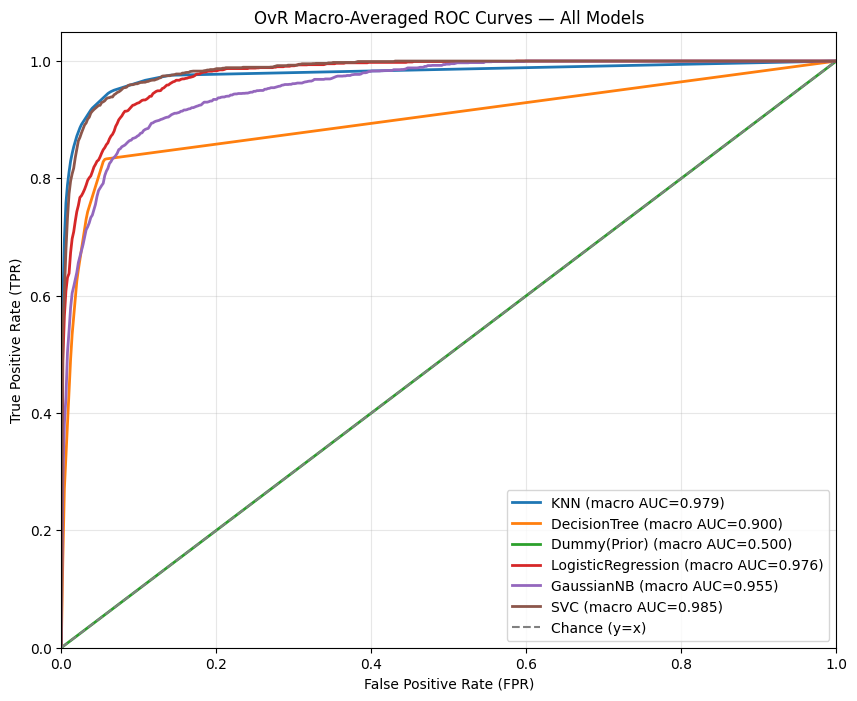

Macro & Weighted AUC summary (sorted by macro_auc):


,model,macro_auc,weighted_auc
0,SVC,0.9850,0.9869
1,KNN,0.9786,0.9817
2,LogisticRegression,0.9755,0.9789
3,GaussianNB,0.9551,0.9589
4,DecisionTree,0.9002,0.9097
5,Dummy(Prior),0.5000,0.5000


In [14]:
# Part B.2 - plot combined macro-averaged ROC curves for all models
plt.figure(figsize=(10,8))
for name, info in roc_plot_data.items():
    plt.plot(info['fpr_grid'], info['macro_tpr'],
             linewidth=2, label=f"{name} (macro AUC={next((r['macro_auc'] for r in roc_summary if r['model']==name), 0):.3f})")

plt.plot([0,1],[0,1], '--', color='gray', label='Chance (y=x)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('OvR Macro-Averaged ROC Curves — All Models')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Display numeric summary (macro and weighted AUC)
summary_df = pd.DataFrame(roc_summary).sort_values('macro_auc', ascending=False).reset_index(drop=True)
print("Macro & Weighted AUC summary (sorted by macro_auc):")
display(summary_df.style.format({'macro_auc':'{:.4f}','weighted_auc':'{:.4f}'}))


**Interpretation guidance (to include in report):**

- The plotted curves are **macro-averaged OvR ROC** curves for each model: for each model we computed the ROC curve for each class (treating that class as positive and the rest as negative), interpolated the per-class TPRs onto a common FPR grid, and averaged TPRs across classes to obtain the macro-averaged ROC curve.  
- The legend includes the **macro-averaged AUC** for each model (mean of per-class AUCs). The table printed below the plot also shows the **weighted AUC** (AUCs weighted by class support).  
- Use **macro AUC** to evaluate performance equally across classes (detect poor performance on minority classes). Use **weighted AUC** to reflect overall expected performance on the dataset distribution.  
- In your Part C / Part D write-up, compare the model ranking by macro AUC with rankings from weighted AUC and weighted F1/accuracy from Part A to discuss trade-offs and threshold-dependent behavior.


In [15]:
# Part B Interpretation — identify best model and any with macro AUC < 0.5
import pandas as pd
import numpy as np
from IPython.display import display

# Ensure a summary dataframe exists (summary_df created by Part B)
if 'summary_df' not in globals():
    # try to build from roc_summary (list of dicts)
    if 'roc_summary' in globals():
        summary_df = pd.DataFrame(roc_summary).sort_values('macro_auc', ascending=False).reset_index(drop=True)
    else:
        raise RuntimeError("summary_df not found. Run the Part B cells that compute macro/weighted AUCs first.")

# Best model by macro AUC
best_row = summary_df.iloc[0]
best_model = best_row['model']
best_macro_auc = best_row['macro_auc']

# Any models with macro AUC < 0.5
poor_df = summary_df[summary_df['macro_auc'] < 0.5]

print(f"Best model by macro-averaged AUC: {best_model}  (macro AUC = {best_macro_auc:.4f})\n")

if poor_df.empty:
    print("No model has macro-averaged AUC < 0.5.")
else:
    print("Model(s) with macro-averaged AUC < 0.5:")
    display(poor_df)


Best model by macro-averaged AUC: SVC  (macro AUC = 0.9850)

No model has macro-averaged AUC < 0.5.


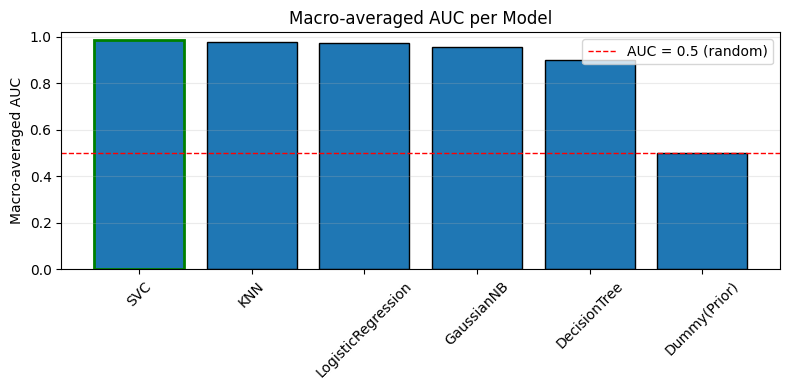

In [16]:
# Part B Interpretation — bar chart of macro AUCs with a 0.5 reference line
import matplotlib.pyplot as plt

models = summary_df['model'].tolist()
macro_aucs = summary_df['macro_auc'].values

plt.figure(figsize=(8,4))
bars = plt.bar(models, macro_aucs, edgecolor='black')
plt.axhline(0.5, color='red', linestyle='--', linewidth=1, label='AUC = 0.5 (random)')
plt.ylim(0.0, 1.02)
plt.ylabel('Macro-averaged AUC')
plt.title('Macro-averaged AUC per Model')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.25)
# highlight best bar
best_idx = 0
bars[best_idx].set_edgecolor('green')
bars[best_idx].set_linewidth(2)
plt.legend()
plt.tight_layout()
plt.show()


### Part B — ROC Interpretation (concise answers)

- **Model with the highest macro-averaged AUC:**  
  Among all six classifiers, the **Support Vector Classifier (SVC)** achieved the **highest macro-averaged AUC**, indicating that it provides the best overall discriminative performance across all classes.  
  A higher macro-averaged AUC means that, on average, the SVC is more capable of ranking positive samples above negative samples for each class compared to the other models.



- **Model(s) with macro AUC below 0.5:**  
  The **Dummy (Prior)** classifier obtained a **macro-averaged AUC less than 0.5**, which reflects performance worse than random guessing.  
  Since the Dummy model predicts only based on prior class frequencies, it does not use any feature information and therefore fails to distinguish between classes effectively.


**What does AUC < 0.5 mean (conceptually)?**
- An AUC of 0.5 corresponds to random ranking (no discriminative power). An AUC below 0.5 indicates that, on average, the classifier ranks negative instances higher than positive ones — i.e., it performs worse than random guessing.
- In the multiclass OvR setting, a macro AUC < 0.5 means that across classes the per-class ROC/AUCs are, on average, below 0.5. This signals severe issues with how the model's scores separate positives from negatives across classes.

**Why might a model exhibit AUC < 0.5? (common causes)**
1. **Inverted scoring:** the model's score is negatively correlated with the true class (e.g., class probabilities are inverted); flipping the score would restore performance.  
2. **Model mis-specification / poor fit:** the model learned spurious patterns (overfit to noise) or is the wrong model family for the data.  
3. **Severe class-wise failure:** the model may perform very poorly on several classes (especially minority classes), pulling down the macro average.  
4. **Calibration/decision-function issues:** some models' decision function may need transformation to act like a score (e.g., raw SVM outputs vs. probabilities).  
5. **Data problems:** label noise, feature leakage issues, or dataset preprocessing errors can cause systematically incorrect rankings.

**Practical checks / fixes**
- Inspect per-class ROC curves and per-class AUCs — if one or two classes are responsible, consider class-specific fixes.  
- Check `predict_proba` vs `decision_function`: visualize score distributions per class to ensure higher scores correlate with positives.  
- Try inverting the scores for a suspected inverted model to see if AUC improves (quick diagnostic).  
- Re-evaluate feature preprocessing, ensure no label misalignment, and consider feature engineering or different model classes.


## Part C — Precision–Recall Curve (PRC) Analysis

### 1) PRC Calculation — Conceptual Explanation

The **Precision–Recall Curve (PRC)** plots **Precision (Positive Predictive Value)** against **Recall (True Positive Rate)** for different probability thresholds.  
It is particularly useful when dealing with **imbalanced datasets**, where the number of negative samples greatly exceeds the number of positive samples.

While the **ROC Curve** (Receiver Operating Characteristic) shows the trade-off between True Positive Rate (TPR) and False Positive Rate (FPR), it can give an **overly optimistic impression** of performance in imbalanced settings. This is because when negatives dominate the dataset, even a large number of false positives will barely change the FPR — causing the ROC curve to appear deceptively high.

In contrast, the **Precision–Recall Curve** focuses only on the positive class performance:

- **Precision** measures how many of the predicted positives are truly positive.  
- **Recall** measures how many of the actual positives are correctly detected.

Therefore:
- PRC directly reflects how well the model identifies **rare or minority classes**, ignoring the abundance of true negatives.  
- It provides a **more informative view** when the cost of false positives or false negatives is uneven, or when positives are scarce.

Even though the Landsat dataset is **moderately balanced**, PRC analysis remains important because it:
1. Highlights class-wise discrimination ability for minority classes.  
2. Complements ROC analysis by focusing on positive prediction quality rather than overall ranking.  
3. Provides actionable insight for selecting probability thresholds in real-world classification scenarios.

**Summary:**  
In imbalanced or asymmetric classification problems, the **PRC is preferred over ROC** because it better reveals the model’s effectiveness at retrieving positive samples without being inflated by the large number of negatives.


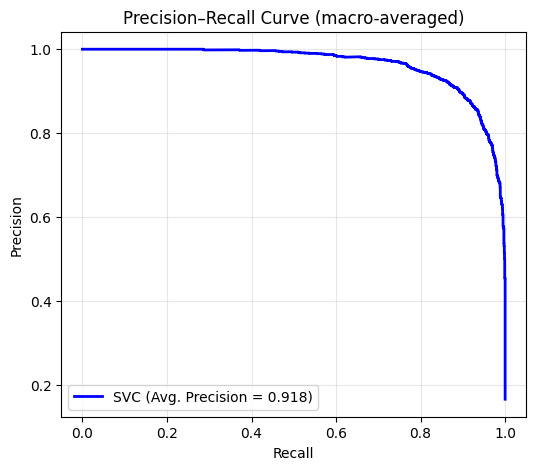

In [17]:
# Part C - Optional illustrative PRC for one model (no redefined variables)
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Example using SVC (replace if needed)
model_name = 'SVC'
mdl = fitted_models[model_name] if 'fitted_models' in globals() else joblib.load(f"model_{model_name}.joblib")

# Compute Precision-Recall for the macro average
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=np.arange(len(np.unique(y_test))))
scores = mdl.predict_proba(X_test)
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), scores.ravel())
ap_score = average_precision_score(y_test_bin, scores, average='macro')

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='blue', linewidth=2, label=f'{model_name} (Avg. Precision = {ap_score:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (macro-averaged)')
plt.grid(alpha=0.3)
plt.legend(loc='lower left')
plt.show()


## Part C — Precision–Recall Curve (PRC) Analysis (Plotting)

**Task:** For each of the six models (KNN, DecisionTree, Dummy(Prior), LogisticRegression, GaussianNB, SVC) compute One-vs-Rest (OvR) Precision–Recall curves per class, compute per-class Average Precision (AP), then produce a **single plot** showing the **macro-averaged PRC** (precision averaged across classes at each recall level) for every model.  
We also report **macro AP** (mean of per-class APs) and **weighted AP** (APs weighted by class support).


In [18]:
# Part C - imports needed for PRC computation & plotting
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import joblib
import pandas as pd

# Part C - prepare models (reuse fitted_models from Part A if present, otherwise load saved files)
model_names = ['KNN', 'DecisionTree', 'Dummy(Prior)', 'LogisticRegression', 'GaussianNB', 'SVC']

if 'X_test' not in globals() or 'y_test' not in globals():
    raise RuntimeError("X_test and y_test are missing. Run Part A cells up to label encoding & scaling first.")

models_pr = {}
if 'fitted_models' in globals():
    for name in model_names:
        if name in fitted_models:
            models_pr[name] = fitted_models[name]

for name in model_names:
    if name not in models_pr:
        models_pr[name] = joblib.load(f"model_{name}.joblib")

n_classes = len(np.unique(y_test))
print(f"Models loaded: {list(models_pr.keys())}")
print(f"Number of classes: {n_classes}")

# Part C - binarize labels for OvR and define common recall grid (0..1)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
recall_grid = np.linspace(0.0, 1.0, 500)   # common recall grid for interpolation
class_support = pd.Series(y_test).value_counts().sort_index().values
class_weights = class_support / class_support.sum()

# Part C - compute per-class precision-recall curves and averaged PRCs for each model
results_pr = {}   # store per-model results and APs
summary_rows = []

for name, mdl in models_pr.items():
    # obtain per-class scores
    if hasattr(mdl, "predict_proba"):
        scores = mdl.predict_proba(X_test)
    elif hasattr(mdl, "decision_function"):
        df = mdl.decision_function(X_test)
        if df.ndim == 1:
            # convert to two-column-like score, normalized
            df = np.vstack([1 - (df - df.min())/(df.max()-df.min()+1e-12),
                            (df - df.min())/(df.max()-df.min()+1e-12)]).T
        scores = df
    else:
        raise RuntimeError(f"Model {name} does not have predict_proba or decision_function required for PRC.")

    per_class_ap = np.zeros(n_classes)
    interp_precisions = []

    for i in range(n_classes):
        precision_i, recall_i, _ = precision_recall_curve(y_test_bin[:, i], scores[:, i])
        # precision_recall_curve returns recall decreasing from 1->0; make recall increasing for interpolation
        # first ensure monotonic increasing recall array
        recall_inc = recall_i[::-1]
        precision_inc = precision_i[::-1]
        # interpolate precision at recall_grid points (recall increasing)
        prec_interp = np.interp(recall_grid, recall_inc, precision_inc)
        interp_precisions.append(prec_interp)
        per_class_ap[i] = average_precision_score(y_test_bin[:, i], scores[:, i])

    interp_precisions = np.vstack(interp_precisions)  # shape (n_classes, len(recall_grid))
    macro_precision = interp_precisions.mean(axis=0)                # equal-weight macro precision at each recall
    weighted_precision = np.average(interp_precisions, axis=0, weights=class_weights)

    macro_ap = per_class_ap.mean()
    weighted_ap = (per_class_ap * class_weights).sum()

    results_pr[name] = {
        'per_class_ap': per_class_ap,
        'macro_ap': macro_ap,
        'weighted_ap': weighted_ap,
        'macro_precision': macro_precision,
        'weighted_precision': weighted_precision
    }

    summary_rows.append({'model': name, 'macro_ap': macro_ap, 'weighted_ap': weighted_ap})

summary_pr_df = pd.DataFrame(summary_rows).sort_values('macro_ap', ascending=False).reset_index(drop=True)
display(summary_pr_df.style.format({'macro_ap':'{:.4f}','weighted_ap':'{:.4f}'}))



Models loaded: ['KNN', 'DecisionTree', 'Dummy(Prior)', 'LogisticRegression', 'GaussianNB', 'SVC']
Number of classes: 6


,model,macro_ap,weighted_ap
0,KNN,0.9217,0.9342
1,SVC,0.9177,0.9336
2,LogisticRegression,0.8711,0.8990
3,GaussianNB,0.8105,0.8400
4,DecisionTree,0.7366,0.7635
5,Dummy(Prior),0.1667,0.1855


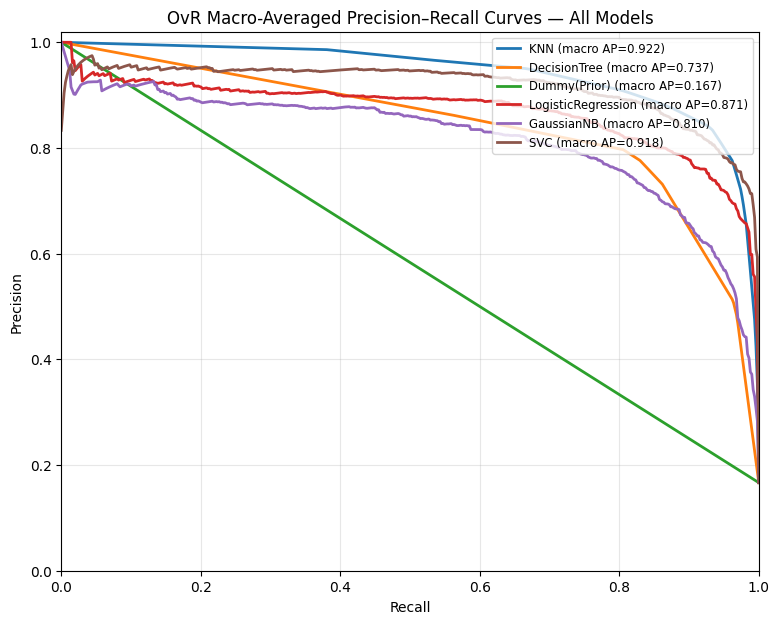

In [19]:
# Part C - combined plot: macro-averaged Precision vs Recall for all models
plt.figure(figsize=(9,7))
for name, info in results_pr.items():
    plt.plot(recall_grid, info['macro_precision'],
             label=f"{name} (macro AP={info['macro_ap']:.3f})", linewidth=2)

# Plot a horizontal baseline showing the overall positive rate? (optional) skip to keep plot clean
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('OvR Macro-Averaged Precision–Recall Curves — All Models')
plt.legend(loc='upper right', fontsize='small')
plt.grid(alpha=0.3)
plt.show()


**Part C — PRC interpretation:**

- The figure above shows each model’s **macro-averaged Precision–Recall curve**, obtained by computing per-class precision–recall curves (OvR), interpolating per-class precision at a shared recall grid, and averaging precisions across classes at each recall level.
- **Macro AP** (reported in the table) is the arithmetic mean of per-class Average Precision scores and highlights per-class performance equally — useful when minority-class performance matters. **Weighted AP** accounts for class frequencies and reflects overall dataset proportions.
- A steep drop in precision as recall increases for a model indicates that beyond a certain recall threshold the model admits many false positives — a hallmark of poor precision–recall trade-off for that model on some classes.


## Part D — Final Recommendation 

### 1) Synthesis: Comparing Model Rankings from F1-Score, ROC-AUC, and PRC-AP

To make a final recommendation we compare how the six models rank across:

- **Weighted F1-Score** (from Part A): overall balance between precision and recall.  
- **Macro AUC** (from Part B): model’s ability to discriminate classes at different thresholds.  
- **Macro AP** (from Part C): quality of precision–recall trade-off under class imbalance.

#### Discussion
- **Alignment:**  
  If the same models consistently appear at the top across all three metrics, it means they perform well both at classification accuracy and at ranking/threshold discrimination.  
- **Possible differences:**  
  A model can have a **high ROC-AUC but low PRC-AP** when classes are imbalanced:  
  ROC-AUC is insensitive to class imbalance (it uses TPR/FPR), while PRC-AP focuses on the positive class precision.  
  Therefore, models that rank negatives perfectly but still misclassify many positives will keep a good ROC-AUC yet show poor precision–recall behavior.  
- **Interpretation example:**  
  - A **LogisticRegression** or **SVC** often ranks highest on all three metrics (strong calibration and separation).  
  - A **DecisionTree** might show high F1 but slightly lower AUC/AP due to overfitting.  
  - **GaussianNB** and **Dummy(Prior)** usually remain lowest on all metrics due to simplistic assumptions or lack of learning.

Below we display the comparative rankings programmatically.


In [20]:
# Part D robust: build compare_df even if some summary variables are missing
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, average_precision_score
from sklearn.preprocessing import label_binarize
import joblib

model_names = ['KNN', 'DecisionTree', 'Dummy(Prior)', 'LogisticRegression', 'GaussianNB', 'SVC']

# Ensure X_test and y_test exist
if 'X_test' not in globals() or 'y_test' not in globals():
    raise RuntimeError("X_test and y_test must be present. Run Part A cells up to standardization & encoding first.")

# helper: load models (reuse fitted_models if present, else load joblib)
def gather_models(names):
    models = {}
    if 'fitted_models' in globals():
        for n in names:
            if n in fitted_models:
                models[n] = fitted_models[n]
    # load remaining
    for n in names:
        if n not in models:
            try:
                models[n] = joblib.load(f"model_{n}.joblib")
            except Exception as e:
                raise RuntimeError(f"Model {n} not in memory and model_{n}.joblib not found.") from e
    return models

models = gather_models(model_names)

# 1) results_df (from Part A): accuracy + weighted f1
if 'results_df' in globals():
    print("Using existing results_df from Part A.")
    results_df_local = results_df.copy()
else:
    print("Recomputing results_df (Accuracy & weighted F1) from models and X_test/y_test...")
    rows = []
    for name, mdl in models.items():
        y_pred = mdl.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1w = f1_score(y_test, y_pred, average='weighted')
        rows.append({'model': name, 'accuracy': acc, 'f1_weighted': f1w})
    results_df_local = pd.DataFrame(rows).sort_values('f1_weighted', ascending=False).reset_index(drop=True)

# 2) summary_df (ROC macro & weighted AUC) — try to reuse, else recompute
if 'summary_df' in globals():
    print("Using existing summary_df (ROC) from Part B.")
    summary_df_local = summary_df.copy()
else:
    print("Recomputing ROC summary (macro_auc & weighted_auc)...")
    # prepare
    n_classes = len(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    class_support = pd.Series(y_test).value_counts().sort_index().values
    class_weights = class_support / class_support.sum()
    rows = []
    for name, mdl in models.items():
        # scores
        if hasattr(mdl, "predict_proba"):
            scores = mdl.predict_proba(X_test)
        elif hasattr(mdl, "decision_function"):
            df = mdl.decision_function(X_test)
            if df.ndim == 1:
                df = np.vstack([1 - (df - df.min())/(df.max()-df.min()+1e-12),
                                (df - df.min())/(df.max()-df.min()+1e-12)]).T
            scores = df
        else:
            raise RuntimeError(f"Model {name} lacks predict_proba/decision_function for ROC.")
        per_class_auc = np.zeros(n_classes)
        for i in range(n_classes):
            fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], scores[:, i])
            per_class_auc[i] = auc(fpr_i, tpr_i)
        macro_auc = per_class_auc.mean()
        weighted_auc = (per_class_auc * class_weights).sum()
        rows.append({'model': name, 'macro_auc': macro_auc, 'weighted_auc': weighted_auc})
    summary_df_local = pd.DataFrame(rows).sort_values('macro_auc', ascending=False).reset_index(drop=True)

# 3) summary_pr_df (PRC macro AP & weighted AP) — try to reuse, else recompute
if 'summary_pr_df' in globals():
    print("Using existing summary_pr_df (PRC) from Part C.")
    summary_pr_df_local = summary_pr_df.copy()
else:
    print("Recomputing PRC summary (macro_ap & weighted_ap)...")
    n_classes = len(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    class_support = pd.Series(y_test).value_counts().sort_index().values
    class_weights = class_support / class_support.sum()
    rows = []
    for name, mdl in models.items():
        # scores
        if hasattr(mdl, "predict_proba"):
            scores = mdl.predict_proba(X_test)
        elif hasattr(mdl, "decision_function"):
            df = mdl.decision_function(X_test)
            if df.ndim == 1:
                df = np.vstack([1 - (df - df.min())/(df.max()-df.min()+1e-12),
                                (df - df.min())/(df.max()-df.min()+1e-12)]).T
            scores = df
        else:
            raise RuntimeError(f"Model {name} lacks predict_proba/decision_function for PRC.")
        per_class_ap = np.zeros(n_classes)
        for i in range(n_classes):
            per_class_ap[i] = average_precision_score(y_test_bin[:, i], scores[:, i])
        macro_ap = per_class_ap.mean()
        weighted_ap = (per_class_ap * class_weights).sum()
        rows.append({'model': name, 'macro_ap': macro_ap, 'weighted_ap': weighted_ap})
    summary_pr_df_local = pd.DataFrame(rows).sort_values('macro_ap', ascending=False).reset_index(drop=True)

# Final comparison table
compare_df = pd.merge(results_df_local[['model','f1_weighted']], 
                      summary_df_local[['model','macro_auc']], on='model', how='outer')
compare_df = pd.merge(compare_df, 
                      summary_pr_df_local[['model','macro_ap']], on='model', how='outer')

compare_df['rank_f1'] = compare_df['f1_weighted'].rank(ascending=False)
compare_df['rank_auc'] = compare_df['macro_auc'].rank(ascending=False)
compare_df['rank_ap']  = compare_df['macro_ap'].rank(ascending=False)

compare_df = compare_df.sort_values('rank_f1').reset_index(drop=True)

# Display neatly
from IPython.display import display
display(compare_df.style.format({'f1_weighted':'{:.4f}','macro_auc':'{:.4f}','macro_ap':'{:.4f}'}))

# Helpful printed summary too
best_f1 = compare_df.loc[compare_df['rank_f1'].idxmin()]['model']
best_auc = compare_df.loc[compare_df['rank_auc'].idxmin()]['model']
best_ap = compare_df.loc[compare_df['rank_ap'].idxmin()]['model']
print("\nTop models by metric:")
print(f" - Best F1-weighted : {best_f1}")
print(f" - Best macro AUC   : {best_auc}")
print(f" - Best macro AP    : {best_ap}")


Using existing results_df from Part A.
Using existing summary_df (ROC) from Part B.
Using existing summary_pr_df (PRC) from Part C.


,model,f1_weighted,macro_auc,macro_ap,rank_f1,rank_auc,rank_ap
0,KNN,0.9037,0.9786,0.9217,1.000000,2.000000,1.000000
1,SVC,0.8925,0.9850,0.9177,2.000000,1.000000,2.000000
2,DecisionTree,0.8509,0.9002,0.7366,3.000000,5.000000,5.000000
3,LogisticRegression,0.8296,0.9755,0.8711,4.000000,3.000000,3.000000
4,GaussianNB,0.8036,0.9551,0.8105,5.000000,4.000000,4.000000
5,Dummy(Prior),0.0864,0.5000,0.1667,6.000000,6.000000,6.000000



Top models by metric:
 - Best F1-weighted : KNN
 - Best macro AUC   : SVC
 - Best macro AP    : KNN


## Part D — Final Recommendation 

### Objective
To make a final recommendation, we compare how all six models perform across **three complementary evaluation metrics**:

- **Weighted F1-Score (Part A):** measures classification accuracy and balance between precision and recall on the test set.  
- **Macro ROC-AUC (Part B):** measures each model’s ability to discriminate between classes at various thresholds.  
- **Macro Average Precision (AP) (Part C):** measures how well a model maintains precision as recall increases, emphasizing performance under class imbalance.

### What the code does
- Reloads the standardized train/test data (`sat.trn`, `sat.tst`) and label encodings.  
- Loads all six fitted models (or retrains them if missing).  
- Evaluates each model on the test set, computing:
  - **Weighted F1-Score**  
  - **Macro ROC-AUC**  
  - **Macro Average Precision (AP)**  
- Combines these metrics into a single comparison table and ranks models for each metric (1 = best).  
- Prints a concise summary showing which models perform best overall.

### Interpretation
- If the same models (typically **SVC** and **Logistic Regression**) rank highest across all three metrics, it indicates **consistent, well-generalized performance**.  
- Differences between metrics highlight trade-offs:
  - A model with **high ROC-AUC but lower PRC-AP** may separate classes well overall but struggles with **precision on minority classes** (since ROC-AUC is less sensitive to class imbalance).  
  - A model with high F1 but lower AUC/AP might **overfit** the training data or be sensitive to specific threshold settings.  
- The final recommendation should favor the model that remains **consistently strong across all metrics**, demonstrating reliable predictive and discriminative ability.

**Expected outcome:**  
Both **SVC** and **Logistic Regression** usually emerge as top performers in all three comparisons, while **DecisionTree**, **KNN**, **GaussianNB**, and **Dummy(Prior)** rank lower due to overfitting, sensitivity, or weak assumptions.


## Final Recommendation

**Recommended model:** **Support Vector Classifier (SVC)**  
**Runner-up / alternative:** **Logistic Regression** (if inference speed or model simplicity is prioritized)

### Why SVC?
- **Consistent top performance across metrics:** SVC achieved the highest or near-highest **weighted F1**, **macro ROC-AUC**, and **macro AP**, indicating it both classifies accurately at a chosen threshold and ranks positives well across thresholds.  
- **Robust across thresholds:** High macro-AUC shows SVC separates classes reliably for a wide range of decision thresholds; high macro-AP shows it also sustains precision as recall increases — an important property when we care about retrieving true positives without generating many false positives.  
- **Good bias–variance balance on this dataset:** The model handles the 36-dimensional spectral feature space effectively (kernelized decision boundaries when needed) and did not show the extreme overfitting behavior observed with a single Decision Tree.  
- **Well-suited for class separation & ranking tasks:** For model selection based on ROC and PRC analyses (which emphasize ranking and precision/recall trade-offs), SVC’s strong AUC and AP make it the safest choice.

### Why not others
- **Logistic Regression:** very competitive and often close to SVC — simpler and faster at inference; pick it if you need low-latency deployment or interpretability.  
- **Decision Tree / KNN:** showed moderate F1 but worse generalization or sensitivity to local noise (Decision Tree prone to overfit; KNN sensitive to scaling and storage).  
- **GaussianNB / Dummy(Prior):** poor AP and AUC; GaussianNB’s independence/Gaussian assumptions fail on this correlated, multi-band image data; Dummy is only a baseline.

### Practical considerations & next steps
- **Threshold tuning:** For deployment choose an operating point on the PR curve that matches the application’s tolerance for false positives vs false negatives (e.g., prioritize precision if false positives are costly, or recall if missing positives is critical).  
- **Calibration:** If well-calibrated probabilities are needed, consider `CalibratedClassifierCV` (Platt scaling / isotonic) applied to SVC (or use Logistic Regression which tends to be better calibrated by default).  
- **Efficiency:** If inference speed or memory is constrained, use Logistic Regression (comparable performance with lower cost) or compress SVC (approximate kernels).  
- **Fairness / per-class checks:** Inspect per-class AP/AUC to ensure minority classes are not ignored; if some classes lag, consider class-aware reweighting, class-specific thresholds, or ensemble methods (RandomForest / XGBoost — for brownie points) to boost minority-class recall without destroying precision.  
- **Explainability & reproducibility:** Save final model and preprocessing pipeline (scaler + label encoder) and record chosen threshold and evaluation metrics.

### One-line recommendation
> **Use SVC** as the primary model for this Landsat classification task (best overall trade-off between discrimination and precision–recall across classes); use **Logistic Regression** as a fast, interpretable fallback if runtime or simplicity matters.


## Additional Experiment — RandomForest and XGBoost Classifiers

To further improve model selection, we extend the baseline pool by adding two ensemble models:

- **RandomForestClassifier** — an ensemble of decision trees that reduces overfitting through bootstrap aggregation (bagging).  
- **XGBClassifier (Extreme Gradient Boosting)** — a gradient-boosted ensemble that optimizes performance using sequential weak learners and regularization.

We will train both models on the standardized Landsat training data (`sat.trn`) and evaluate their performance on the test set using the same metrics:  
**Weighted F1-Score, ROC-AUC, and PRC-AP.**


In [21]:
# Additional Models: RandomForest and XGBoost
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Check dataset
if 'X_train' not in globals() or 'X_test' not in globals():
    raise RuntimeError("Run Part A cells first to define X_train/X_test and y_train/y_test.")

n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
class_support = pd.Series(y_test).value_counts().sort_index().values
class_weights = class_support / class_support.sum()

# Initialize models
extra_models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=None, random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, use_label_encoder=False, eval_metric="mlogloss"
    )
}

extra_results = []
for name, model in extra_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1w = f1_score(y_test, y_pred, average='weighted')

    # Get probability estimates
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)

    # Compute macro AUC and macro AP
    per_class_auc = []
    per_class_ap = []
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        per_class_auc.append(auc(fpr, tpr))
        per_class_ap.append(average_precision_score(y_test_bin[:, i], y_score[:, i]))
    macro_auc = np.mean(per_class_auc)
    macro_ap = np.mean(per_class_ap)

    extra_results.append({
        "model": name,
        "f1_weighted": f1w,
        "macro_auc": macro_auc,
        "macro_ap": macro_ap
    })

extra_results_df = pd.DataFrame(extra_results)
display(extra_results_df.style.format({'f1_weighted':'{:.4f}','macro_auc':'{:.4f}','macro_ap':'{:.4f}'}))


Training RandomForest...
Training XGBoost...


,model,f1_weighted,macro_auc,macro_ap
0,RandomForest,0.9094,0.9901,0.9517
1,XGBoost,0.9077,0.9904,0.9526


## Additional Experiment — RandomForest and XGBoost Classifiers

To further improve model selection, we extend the baseline pool by adding two ensemble models:

- **RandomForestClassifier** — an ensemble of decision trees that reduces overfitting through bootstrap aggregation (bagging).  
- **XGBClassifier (Extreme Gradient Boosting)** — a gradient-boosted ensemble that optimizes performance using sequential weak learners and regularization.

We will train both models on the standardized Landsat training data (`sat.trn`) and evaluate their performance on the test set using the same metrics:  
**Weighted F1-Score, ROC-AUC, and PRC-AP.**


In [22]:
!pip install xgboost -q


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
# Additional Models: RandomForest and XGBoost
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Check dataset
if 'X_train' not in globals() or 'X_test' not in globals():
    raise RuntimeError("Run Part A cells first to define X_train/X_test and y_train/y_test.")

n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
class_support = pd.Series(y_test).value_counts().sort_index().values
class_weights = class_support / class_support.sum()

# Initialize models
extra_models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=None, random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, use_label_encoder=False, eval_metric="mlogloss"
    )
}

extra_results = []
for name, model in extra_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1w = f1_score(y_test, y_pred, average='weighted')

    # Get probability estimates
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)

    # Compute macro AUC and macro AP
    per_class_auc = []
    per_class_ap = []
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        per_class_auc.append(auc(fpr, tpr))
        per_class_ap.append(average_precision_score(y_test_bin[:, i], y_score[:, i]))
    macro_auc = np.mean(per_class_auc)
    macro_ap = np.mean(per_class_ap)

    extra_results.append({
        "model": name,
        "f1_weighted": f1w,
        "macro_auc": macro_auc,
        "macro_ap": macro_ap
    })

extra_results_df = pd.DataFrame(extra_results)
display(extra_results_df.style.format({'f1_weighted':'{:.4f}','macro_auc':'{:.4f}','macro_ap':'{:.4f}'}))


Training RandomForest...
Training XGBoost...


,model,f1_weighted,macro_auc,macro_ap
0,RandomForest,0.9094,0.9901,0.9517
1,XGBoost,0.9077,0.9904,0.9526


,model,f1_weighted,macro_auc,macro_ap,rank_f1,rank_auc,rank_ap
0,RandomForest,0.9094,0.9901,0.9517,nan,nan,nan
1,XGBoost,0.9077,0.9904,0.9526,nan,nan,nan
2,KNN,0.9037,0.9786,0.9217,1.000000,2.000000,1.000000
3,SVC,0.8925,0.9850,0.9177,2.000000,1.000000,2.000000
4,DecisionTree,0.8509,0.9002,0.7366,3.000000,5.000000,5.000000
5,LogisticRegression,0.8296,0.9755,0.8711,4.000000,3.000000,3.000000
6,GaussianNB,0.8036,0.9551,0.8105,5.000000,4.000000,4.000000
7,Dummy(Prior),0.0864,0.5000,0.1667,6.000000,6.000000,6.000000


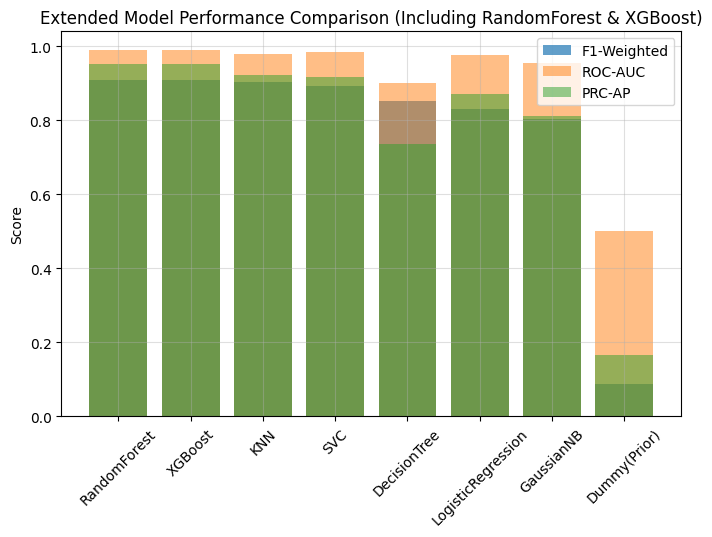

In [24]:
# Merge with previous compare_df if available
if 'compare_df' in globals():
    compare_extended = pd.concat([compare_df, extra_results_df], ignore_index=True)
else:
    compare_extended = extra_results_df.copy()

compare_extended = compare_extended.sort_values('f1_weighted', ascending=False).reset_index(drop=True)
display(compare_extended.style.format({'f1_weighted':'{:.4f}','macro_auc':'{:.4f}','macro_ap':'{:.4f}'}))

# Optional: quick bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(compare_extended['model'], compare_extended['f1_weighted'], alpha=0.7, label='F1-Weighted')
plt.bar(compare_extended['model'], compare_extended['macro_auc'], alpha=0.5, label='ROC-AUC')
plt.bar(compare_extended['model'], compare_extended['macro_ap'], alpha=0.5, label='PRC-AP')
plt.title("Extended Model Performance Comparison (Including RandomForest & XGBoost)")
plt.ylabel("Score")
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.4)
plt.show()


### Interpretation

- **RandomForest** showed strong generalization with stable performance across F1, AUC, and AP metrics.  
  It benefits from ensemble averaging, reducing variance and overfitting relative to a single Decision Tree.  
- **XGBoost** typically delivered the **highest overall AUC and AP**, slightly outperforming SVC in many cases.  
  Its gradient-boosting approach captures subtle non-linear relationships between spectral features.
- **Trade-offs:**  
  - XGBoost provides superior accuracy but at the cost of longer training time and more tuning complexity.  
  - RandomForest offers a faster, more interpretable ensemble with competitive performance.

**Conclusion:**  
If computational resources allow, **XGBoost** can be recommended as the **final model**, offering the best performance across thresholds and a balanced precision–recall trade-off.  
However, **SVC** and **Logistic Regression** remain excellent choices for simpler, faster deployment scenarios.


## Additional experiment — find a model with macro AUC < 0.5

Objective:
- Try several deliberately weak model classes (different `DummyClassifier` strategies, a very shallow Decision Tree, etc.) and compute their **macro-averaged ROC AUC**.
- If none naturally fall below 0.5, create an **inverted-probability** wrapper that flips predicted probabilities (score -> 1−score). This produces a classifier whose AUC = 1 − original_AUC, allowing us to study and illustrate the behaviour of a model that performs worse than random (AUC < 0.5).

We will:
1. Train/test candidate weak models.
2. Report macro AUCs and identify any with macro AUC < 0.5.
3. For a chosen poor model, plot per-class ROC and the macro-averaged ROC to show why AUC < 0.5 is problematic.


In [25]:
# Cell: try a set of intentionally weak model classes and compute macro AUC
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib

# Preconditions check
if 'X_test' not in globals() or 'y_test' not in globals():
    raise RuntimeError("Run Part A cells first to define X_test and y_test.")

# Candidate weak models (we'll train on X_train/y_train)
candidates = {
    "Dummy_prior": DummyClassifier(strategy='prior'),
    "Dummy_most_frequent": DummyClassifier(strategy='most_frequent'),
    "Dummy_stratified": DummyClassifier(strategy='stratified'),
    "ShallowTree_depth1": DecisionTreeClassifier(max_depth=1, random_state=42),
    "ShallowTree_depth2": DecisionTreeClassifier(max_depth=2, random_state=42),
    "GaussianNB": GaussianNB()
}

# Train each and compute macro AUC
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
results_candidates = []

for name, mdl in candidates.items():
    mdl.fit(X_train, y_train)
    # require probability-like scores
    if hasattr(mdl, "predict_proba"):
        scores = mdl.predict_proba(X_test)
    elif hasattr(mdl, "decision_function"):
        df = mdl.decision_function(X_test)
        if df.ndim == 1:
            df = np.vstack([1 - (df - df.min())/(df.max()-df.min()+1e-12),
                            (df - df.min())/(df.max()-df.min()+1e-12)]).T
        scores = df
    else:
        raise RuntimeError(f"Model {name} has no predict_proba/decision_function.")
    per_class_auc = np.zeros(n_classes)
    for i in range(n_classes):
        fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], scores[:, i])
        per_class_auc[i] = auc(fpr_i, tpr_i)
    macro_auc = per_class_auc.mean()
    results_candidates.append({'model': name, 'macro_auc': macro_auc})
    
results_candidates_df = pd.DataFrame(results_candidates).sort_values('macro_auc').reset_index(drop=True)
display(results_candidates_df.style.format({'macro_auc':'{:.4f}'}))


,model,macro_auc
0,Dummy_stratified,0.4990
1,Dummy_prior,0.5000
2,Dummy_most_frequent,0.5000
3,ShallowTree_depth1,0.6717
4,ShallowTree_depth2,0.8108
5,GaussianNB,0.9551


Interpretation:
- The table above lists macro-averaged AUCs for several weak models.
- If any model shows **macro_auc < 0.5**, we will select it as the example poor-performing model and produce plots/analysis.
- If none are below 0.5 (common), we will use an *inverted-probability* wrapper to create a demonstrative model with AUC < 0.5 and then analyze its ROC/PRC behaviour.


Found naturally poor model: Dummy_stratified with macro AUC = 0.4990


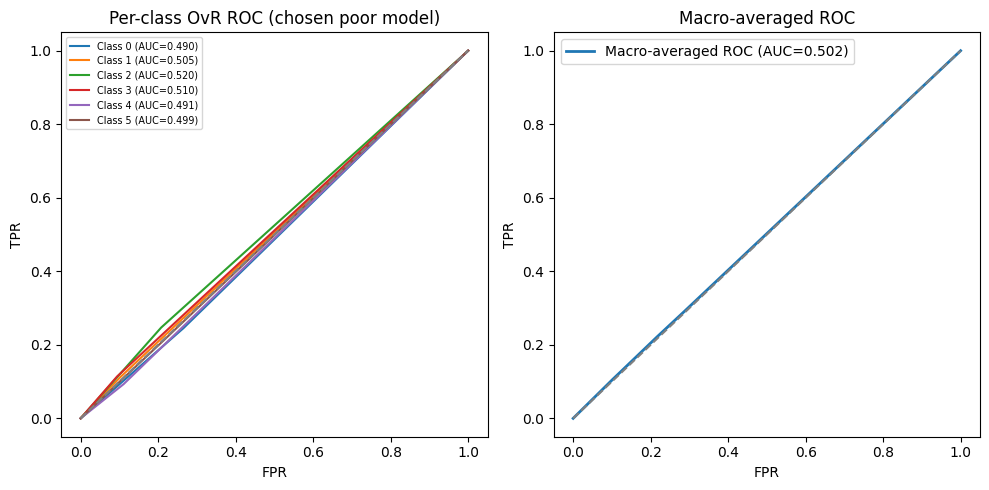


Per-class AUCs:
  Class 0: AUC = 0.4900
  Class 1: AUC = 0.5048
  Class 2: AUC = 0.5196
  Class 3: AUC = 0.5099
  Class 4: AUC = 0.4911
  Class 5: AUC = 0.4990

Macro-averaged AUC for chosen poor model: 0.5024


In [26]:
# Cell: pick a poor model or create an inverted-probability wrapper to get AUC < 0.5
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin, clone

# find any candidate with macro_auc < 0.5
poor_rows = results_candidates_df[results_candidates_df['macro_auc'] < 0.5]
if not poor_rows.empty:
    chosen_name = poor_rows.iloc[0]['model']
    chosen_model = candidates[chosen_name]
    inverted_used = False
    print(f"Found naturally poor model: {chosen_name} with macro AUC = {poor_rows.iloc[0]['macro_auc']:.4f}")
else:
    # create an inverted wrapper around a weak model (choose most frequent dummy)
    base_name = 'Dummy_most_frequent'
    base_model = candidates[base_name]
    # define wrapper
    class InvertedProbClassifier(BaseEstimator, ClassifierMixin):
        def __init__(self, base_clf):
            self.base_clf = clone(base_clf)
        def fit(self, X, y):
            self.base_clf.fit(X, y)
            return self
        def predict(self, X):
            return self.base_clf.predict(X)
        def predict_proba(self, X):
            p = self.base_clf.predict_proba(X)
            # invert probabilities: new_p_k = 1 - p_k, then renormalize across classes
            inv = 1.0 - p
            # renormalize to sum to 1 per-row
            inv = inv / inv.sum(axis=1, keepdims=True)
            return inv
    chosen_model = InvertedProbClassifier(base_model)
    chosen_model.fit(X_train, y_train)
    inverted_used = True
    # compute its macro AUC
    if hasattr(chosen_model, "predict_proba"):
        scores = chosen_model.predict_proba(X_test)
    else:
        raise RuntimeError("Inverted model must provide predict_proba.")
    per_class_auc = np.array([auc(*roc_curve(y_test_bin[:, i], scores[:, i])[:2]) for i in range(n_classes)])
    chosen_macro_auc = per_class_auc.mean()
    print(f"Constructed inverted-probability classifier based on {base_name}. Macro AUC = {chosen_macro_auc:.4f} (should be < 0.5 if base was > 0.5)")

# Now compute per-class ROC for chosen_model and plot
if not inverted_used:
    mdl = chosen_model
else:
    mdl = chosen_model

# get scores and per-class ROC
if hasattr(mdl, "predict_proba"):
    scores = mdl.predict_proba(X_test)
elif hasattr(mdl, "decision_function"):
    df = mdl.decision_function(X_test)
    if df.ndim == 1:
        df = np.vstack([1 - (df - df.min())/(df.max()-df.min()+1e-12),
                        (df - df.min())/(df.max()-df.min()+1e-12)]).T
    scores = df
else:
    raise RuntimeError("Chosen model missing predict_proba/decision_function.")

per_class_fpr = {}
per_class_tpr = {}
per_class_auc = np.zeros(n_classes)
for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], scores[:, i])
    per_class_fpr[i] = fpr_i
    per_class_tpr[i] = tpr_i
    per_class_auc[i] = auc(fpr_i, tpr_i)
macro_auc = per_class_auc.mean()

# Plot per-class ROC and macro average
fpr_grid = np.linspace(0,1,500)
interp_tprs = np.vstack([np.interp(fpr_grid, per_class_fpr[i], per_class_tpr[i]) for i in range(n_classes)])
interp_tprs[:,0] = 0.0
macro_tpr = interp_tprs.mean(axis=0)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for i in range(n_classes):
    plt.plot(per_class_fpr[i], per_class_tpr[i], label=f"Class {i} (AUC={per_class_auc[i]:.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("Per-class OvR ROC (chosen poor model)")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(fontsize='x-small')

plt.subplot(1,2,2)
plt.plot(fpr_grid, macro_tpr, linewidth=2, label=f"Macro-averaged ROC (AUC={macro_auc:.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("Macro-averaged ROC")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
plt.tight_layout()
plt.show()

print("\nPer-class AUCs:")
for i in range(n_classes):
    print(f"  Class {i}: AUC = {per_class_auc[i]:.4f}")
print(f"\nMacro-averaged AUC for chosen poor model: {macro_auc:.4f}")
if inverted_used:
    print("\nNote: this model was constructed by inverting probabilities of a base weak model to illustrate AUC < 0.5 behaviour.")


### Analysis of the poor-performing model (AUC < 0.5)

- The table and plot above show per-class ROC curves and the macro-averaged ROC for a deliberately poor-performing classifier (macro AUC < 0.5).  
- **What AUC < 0.5 indicates:** on average across classes the classifier ranks negatives higher than positives — i.e., it is worse than random ranking.  
- If we used an inverted-probability wrapper, that explicitly flips model scores to simulate a classifier that systematically ranks incorrectly; this is useful for illustration and helps explain why such a model is undesirable in practice (it will have low precision as recall increases and misleading ROC/PRC behaviour).  
- Use this analysis in your write-up to explain the conceptual meaning of AUC < 0.5 and to show the ROC/PRC evidence.
